<a href="https://colab.research.google.com/github/abartnof/worldwide_ed/blob/main/education.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages('ggrepel')
install.packages('lavaan')
install.packages('maps')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘tmvnsim’, ‘mnormt’, ‘pbivnorm’, ‘numDeriv’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [7]:
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(lavaan))
suppressPackageStartupMessages(library(tidyverse))
options(repr.plot.width = 12, repr.plot.height = 8)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


# ETL

In [8]:
Data <- new.env()

In [9]:
Data$RawRatio <- read_csv('https://raw.githubusercontent.com/abartnof/worldwide_ed/main/ratio.csv', col_types = cols(.default = 'c'))

In [10]:
Data$Ratio <-
  Data$RawRatio %>%
  select(
    country_abbrev = COUNTRY,
    country = Country,
    ed_level_code = 'ISC11_LEVEL_CAT',
    ed_level = 'Level of education',
    sector = 'Reference sector',
    indicator = Indicator,
    year = Year,
    value = Value
  ) %>%
  filter(
    indicator == 'Ratio of students to teaching staff by type of institutions',
    sector == 'All public and private educational institutions') %>%
  mutate(
    value = parse_number(value),
    country = recode(country,
      'Russia' = 'Russian Federation')
  ) %>%
  drop_na(value) %>%
  
  # Aggregate across grade levels
  group_by(country, indicator) %>%
  summarize(value = median(value)) %>%
  ungroup %>%

  mutate(
    percentile = ecdf(value)(value),
    percentile_bin = cut(percentile, breaks = seq(0, 1, by = 0.2), include.lowest = T, ordered_result = T)
  )

`summarise()` has grouped output by 'country'. You can override using the `.groups` argument.



In [11]:
Data$RawTimeWorking <- read_csv('https://raw.githubusercontent.com/abartnof/worldwide_ed/main/time_working.csv', col_types = cols(.default = 'c'))

In [12]:
Data$TimeWorking <-
  Data$RawTimeWorking %>%
  select(
    country = Country,
    indicator = Indicator,
    value = Value
  ) %>%
  filter(indicator == 
    'Total statutory working time per school year, in hours (teachers)'
  ) %>%
  mutate(
    value = parse_number(value),
  ) %>%
  drop_na(value) %>%

  # Aggregate over grades
  group_by(country, indicator) %>%
  summarize(value = median(value)) %>%
  ungroup %>%

  select(country, indicator, value) %>%
  mutate(
    percentile = ecdf(value)(value),
    percentile_bin = cut(percentile, breaks = seq(0, 1, by = 0.2), include.lowest = T, ordered_result = T)
  )

`summarise()` has grouped output by 'country'. You can override using the `.groups` argument.



In [13]:
Data$RawSalary <- read_csv('https://raw.githubusercontent.com/abartnof/worldwide_ed/main/salary.csv', col_types = cols(.default = 'c'))

In [14]:
Data$Salary <- 
  Data$RawSalary %>%
  select(
    country = Country,
    gender = Gender, 
    indicator = Indicator,
    value = Value
  ) %>%
  filter(
    str_detect(indicator, 'PPP'),
    gender == 'Total',
    country != 'European Union 23 members in OECD',
    country != 'OECD Average') %>%
  mutate(
      value = parse_number(value),
  ) %>%
  drop_na(value) %>%
  # Aggregate over grades
  group_by(country, indicator) %>%
  summarize(value = median(value)) %>%
  ungroup %>%

  mutate(
    percentile = ecdf(value)(value),
    percentile_bin = cut(percentile, breaks = seq(0, 1, by = 0.2), include.lowest = T, ordered_result = T)
  )

`summarise()` has grouped output by 'country'. You can override using the `.groups` argument.



In [15]:
Data$RawSocialOutcomes <- read_csv('https://raw.githubusercontent.com/abartnof/worldwide_ed/main/social_outcomes.csv', col_types = cols(.default = 'c'))

In [16]:
Data$SocialOutcomes <-
  Data$RawSocialOutcomes %>%
  filter(
    Age == '25-64 years',
    `ISCED-A 2011` == 'All levels of education',
    Measure == 'Value',
    Indicator !=  'Percentage of adults who reported that over the last 12 months it has been difficult for them to concentrate at work because of their family responsibilities'
    ) %>%
  select(
      country = Country,
      indicator = Indicator,
      value = Value
  ) %>%
  mutate(
    value = parse_number(value),
    country = recode(country,
      'England' = 'England (UK)',
      'Russia' = 'Russian Federation'),
    indicator_concise = recode(indicator,
    'Mean number of hours worked per week in the main job among employed adults' = 'hours_worked',
    'Percentage of employed adults who report having a high or very high flexibility of working hours in their main job' = 'work_flexibility',
    'Percentage of adults who reported that over the last 12 months it has been difficult for them to fulfil their family responsibilities because of the amount of time they spend at work' = 'conflict_work_family_time',
    'Percentage of adults who read books at least once a week, by labour-force status, gender, age and educational attainment' = 'read_books'
    )
  ) 

The PISA subject scores correlate so highly, they're essentially
redundant (correlation matrix a few cells down, [right here](https://colab.research.google.com/drive/1GMMEc6AJJ7UOKEx_FHjYNVeMG9jL0ij5#scrollTo=0yLqR8uafTsU)). 
As a result, we can make life simple and just represent each country's PISA performance as the median value of these three evaluations.

In [17]:
Data$RawPisa <- read_csv('https://raw.githubusercontent.com/abartnof/worldwide_ed/main/pisa_2018.csv', col_types = 'icic')

In [94]:
Data$Pisa <-
  Data$RawPisa %>%
  mutate(
    country = recode(country,
      'China (B-S-J-Z)[note 1]' = 'China (People\'s Republic of)',
      'Macau(China)' = 'Macau (China)',
      'Hong Kong(China)' = 'Hong Kong (China)',
      'Russia' = 'Russian Federation',
      'Slovakia' = 'Slovak Republic',
      'South Korea' = 'Korea'
    ))

Data$PisaAgg <-
  Data$Pisa %>%
  drop_na(score) %>%
  group_by(country) %>%
  summarize(
    score = median(score)
    ) %>%
  ungroup %>%
  mutate(
    pisa_sd = as.vector(scale(score)),
    pisa_percentile = ecdf(score)(score),
    pisa_percentile_bin = cut(pisa_percentile, breaks = seq(0, 1, by = 0.2), include.lowest = T, ordered_result = T)
    )

In [19]:
# Data$RawTimeUse <- read_csv('https://raw.githubusercontent.com/abartnof/worldwide_ed/main/time_use.csv', col_types = cols(Value = 'd', .default = 'c'))

In [20]:
# Data$TimeUse <-
#   Data$RawTimeUse %>%
#   filter(Sex == 'Total') %>%
#   rename(country = Country, activity = Description, time = Time, minutes = Value) %>%
#   mutate(
#     hours = minutes / 60,
#     activity = fct_relevel(activity, 'Other', after = Inf)
#     ) %>%
#   select(country, activity, hours, minutes)

In [22]:
# Use the maps package to get a map of the world

Data$World <- map_data('world')

Data$World <-
  Data$World %>%
    mutate(
      region = recode(region,
        'China' = 'China (People\'s Republic of)',
        'South Korea' = 'Korea',
        'Russia' = 'Russian Federation',
        'Slovakia' = 'Slovak Republic',
        'UK' = 'United Kingdom',
        'USA' = 'United States',
        'Macedonia' = 'North Macedonia'
        )) %>%
    filter(region != 'Antarctica')

# Pisa subject correlations
The Spearman's rho between the subjects is uniformly 1, or nearly 1.

In [33]:
rho <-
  Data$Pisa %>%
  spread(subject, score) %>%
  select(mathematics, reading, science) %>%
  cor(use = 'pairwise.complete.obs', method = 's')

rho[upper.tri(rho, diag = T)] <- NA_real_
rho

,mathematics,reading,science
mathematics,NA,NA,NA
reading,1.000000,NA,NA
science,0.996696,1,NA


# Maps and IVs

In [98]:
ratio_labels <- c(
    '[0,0.2] (fewer students per teacher)', 
    '(0.2,0.4]', 
    '(0.4,0.6]',
    '(0.6,0.8]',
    '(0.8,1] (more students per teacher)')

salary_labels <- c(
    '[0,0.2] (smaller salary)', 
    '(0.2,0.4]', 
    '(0.4,0.6]',
    '(0.6,0.8]',
    '(0.8,1] (larger salary)')

time_use_labels <- c(
    '[0,0.2] (less time)', 
    '(0.2,0.4]', 
    '(0.4,0.6]',
    '(0.6,0.8]',
    '(0.8,1] (more time)')

pisa_labels <- c(
    '[0,0.2] (worse score)', 
    '(0.2,0.4]', 
    '(0.4,0.6]',
    '(0.6,0.8]',
    '(0.8,1] (better score)')

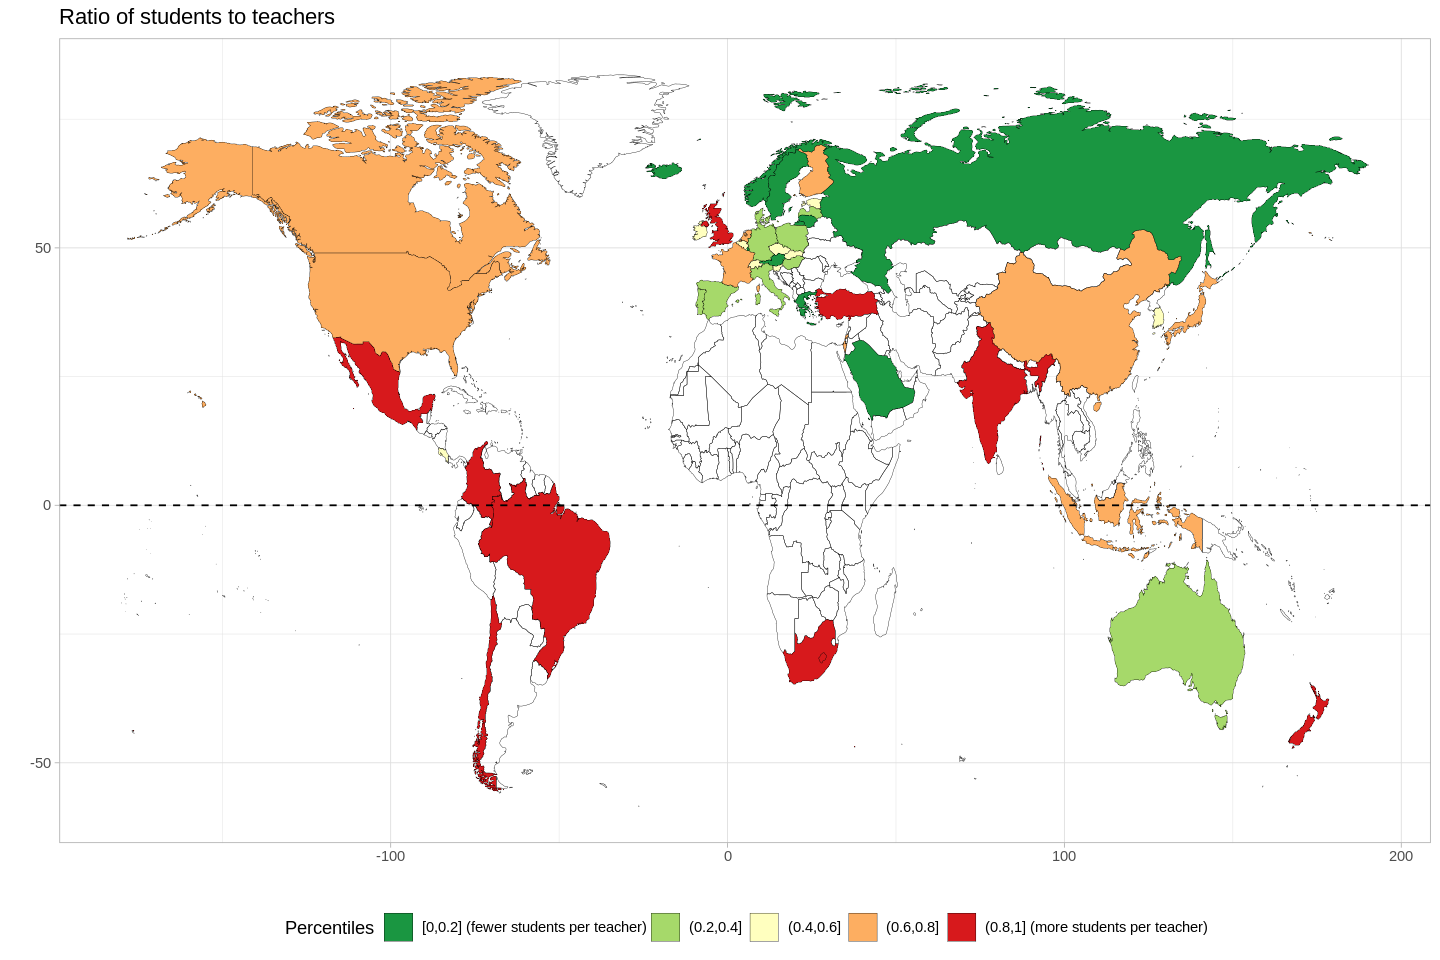

In [35]:
Data$Ratio %>%
right_join(Data$World, by = c('country' = 'region')) %>%

ggplot(., aes(x = long, y = lat, group = group, fill = percentile_bin)) +
geom_polygon(color = 'black', size = 0.1) +
geom_hline(yintercept = 0, linetype = 'dashed') +
scale_fill_brewer(
  palette = 'RdYlGn', 
  direction = -1,
  breaks = c(
    '[0,0.2]',
    '(0.2,0.4]',
    '(0.4,0.6]',
    '(0.6,0.8]',
    '(0.8,1]'),
  labels = ratio_labels) +
guides(fill = guide_legend(nrow = 1)) +
theme_light() +
theme(legend.position = 'bottom') +
labs(x = '', y = '', 
  title = 'Ratio of students to teachers', 
  fill = 'Percentiles')

In [36]:
Data$Salary$indicator[[1]]

[1] "\"Annual average salaries (including bonuses and allowances) of teachers in public institutions, in equivalent USD converted using PPPs for private consumption\""

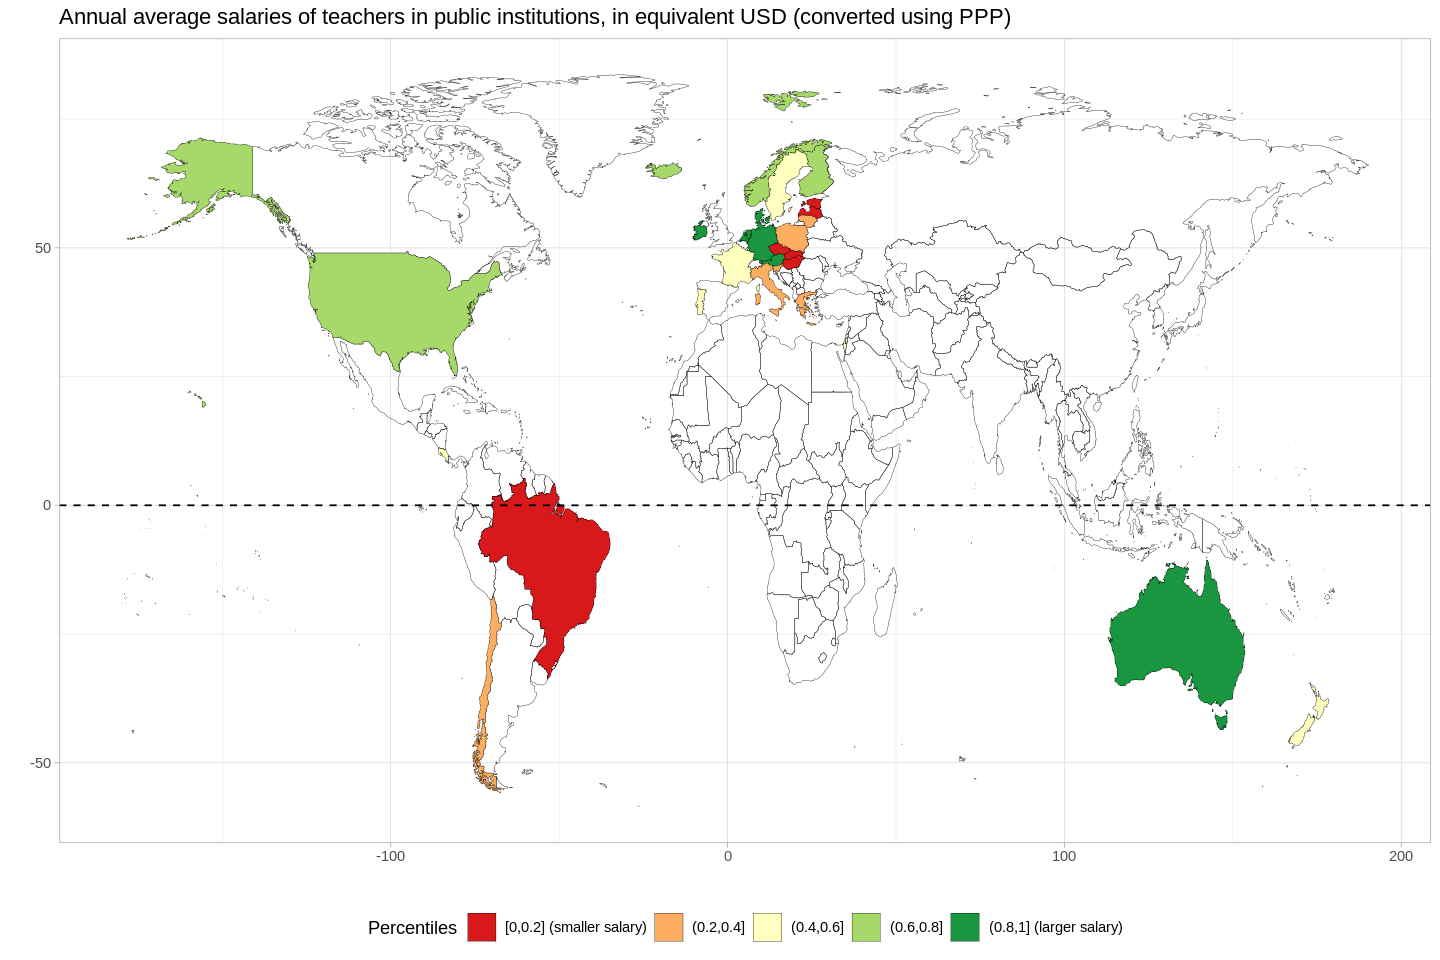

In [37]:
Data$Salary %>%
right_join(Data$World, by = c('country' = 'region')) %>%

ggplot(., aes(x = long, y = lat, group = group, fill = percentile_bin)) +
geom_polygon(color = 'black', size = 0.1) +
geom_hline(yintercept = 0, linetype = 'dashed') +
scale_fill_brewer(
  palette = 'RdYlGn', 
  # direction = -1,
  breaks = c(
    '[0,0.2]',
    '(0.2,0.4]',
    '(0.4,0.6]',
    '(0.6,0.8]',
    '(0.8,1]'),
  labels = salary_labels) +
guides(fill = guide_legend(nrow = 1)) +
theme_light() +
theme(legend.position = 'bottom') +
labs(x = '', y = '', 
  title = 'Annual average salaries of teachers in public institutions, in equivalent USD (converted using PPP)', 
  fill = 'Percentiles')

In [38]:
Data$TimeWorking$indicator[[1]]

[1] "Total statutory working time per school year, in hours (teachers)"

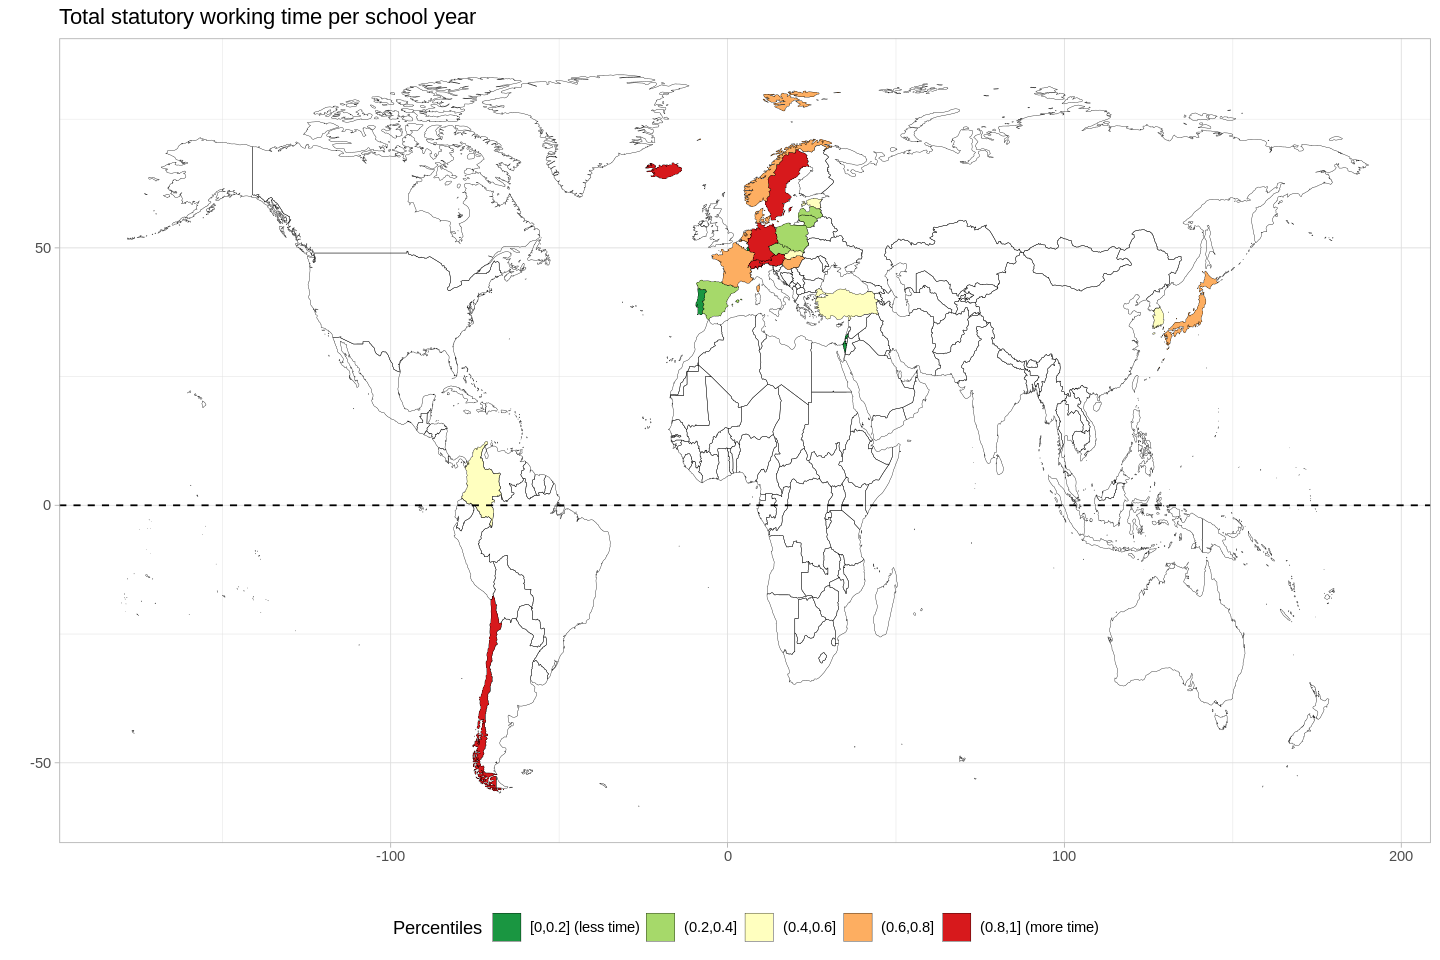

In [39]:
Data$TimeWorking %>%
right_join(Data$World, by = c('country' = 'region')) %>%

ggplot(., aes(x = long, y = lat, group = group, fill = percentile_bin)) +
geom_polygon(color = 'black', size = 0.1) +
geom_hline(yintercept = 0, linetype = 'dashed') +
scale_fill_brewer(
  palette = 'RdYlGn', 
  direction = -1,
  breaks = c(
    '[0,0.2]',
    '(0.2,0.4]',
    '(0.4,0.6]',
    '(0.6,0.8]',
    '(0.8,1]'),
  labels = time_use_labels) +
guides(fill = guide_legend(nrow = 1)) +
theme_light() +
theme(legend.position = 'bottom') +
labs(x = '', y = '', 
  title = 'Total statutory working time per school year', 
  fill = 'Percentiles')

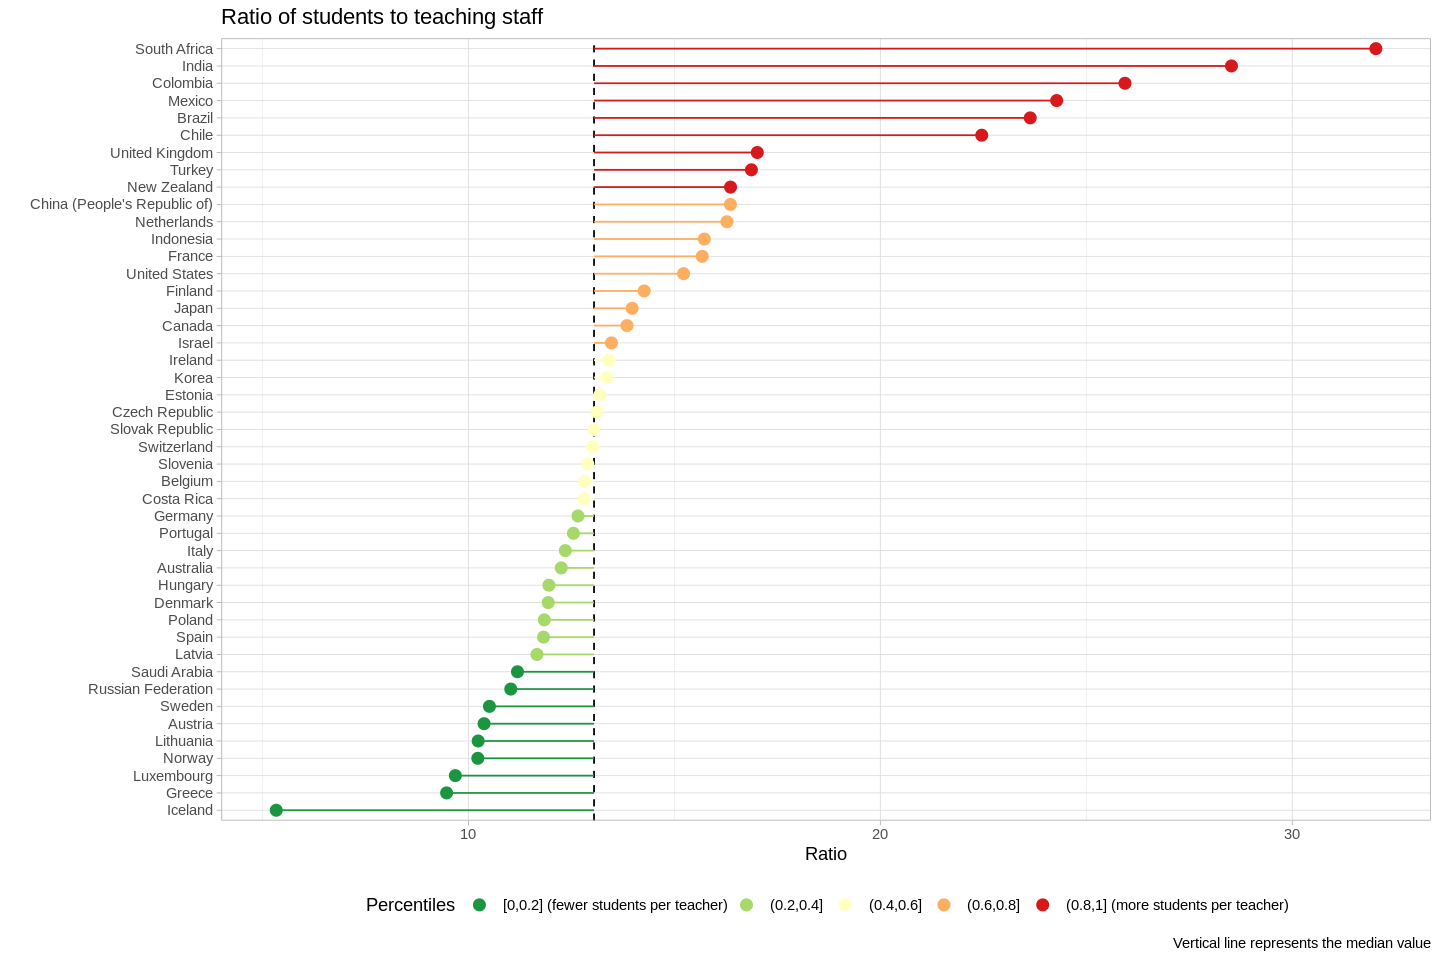

In [108]:
Data$Ratio %>%
drop_na %>%
mutate(
  country = fct_reorder(country, value),
  median_value = median(value)
  # centered_value = value - median_value
) %>%

ggplot(aes(x = country, y = value, color = percentile_bin)) +
geom_hline(aes(yintercept = median_value), linetype = 'dashed') +
geom_segment(aes(xend = country, yend = median_value), show.legend = F) +
geom_point(size = 3) +
coord_flip() +
scale_color_brewer(
  palette = 'RdYlGn',
  direction = -1,
  labels = ratio_labels) +
theme_light() +
theme(legend.position = 'bottom') +
labs(
  x = '', 
  title = 'Ratio of students to teaching staff', 
  y = 'Ratio', 
  color = 'Percentiles',
  caption = 'Vertical line represents the median value')

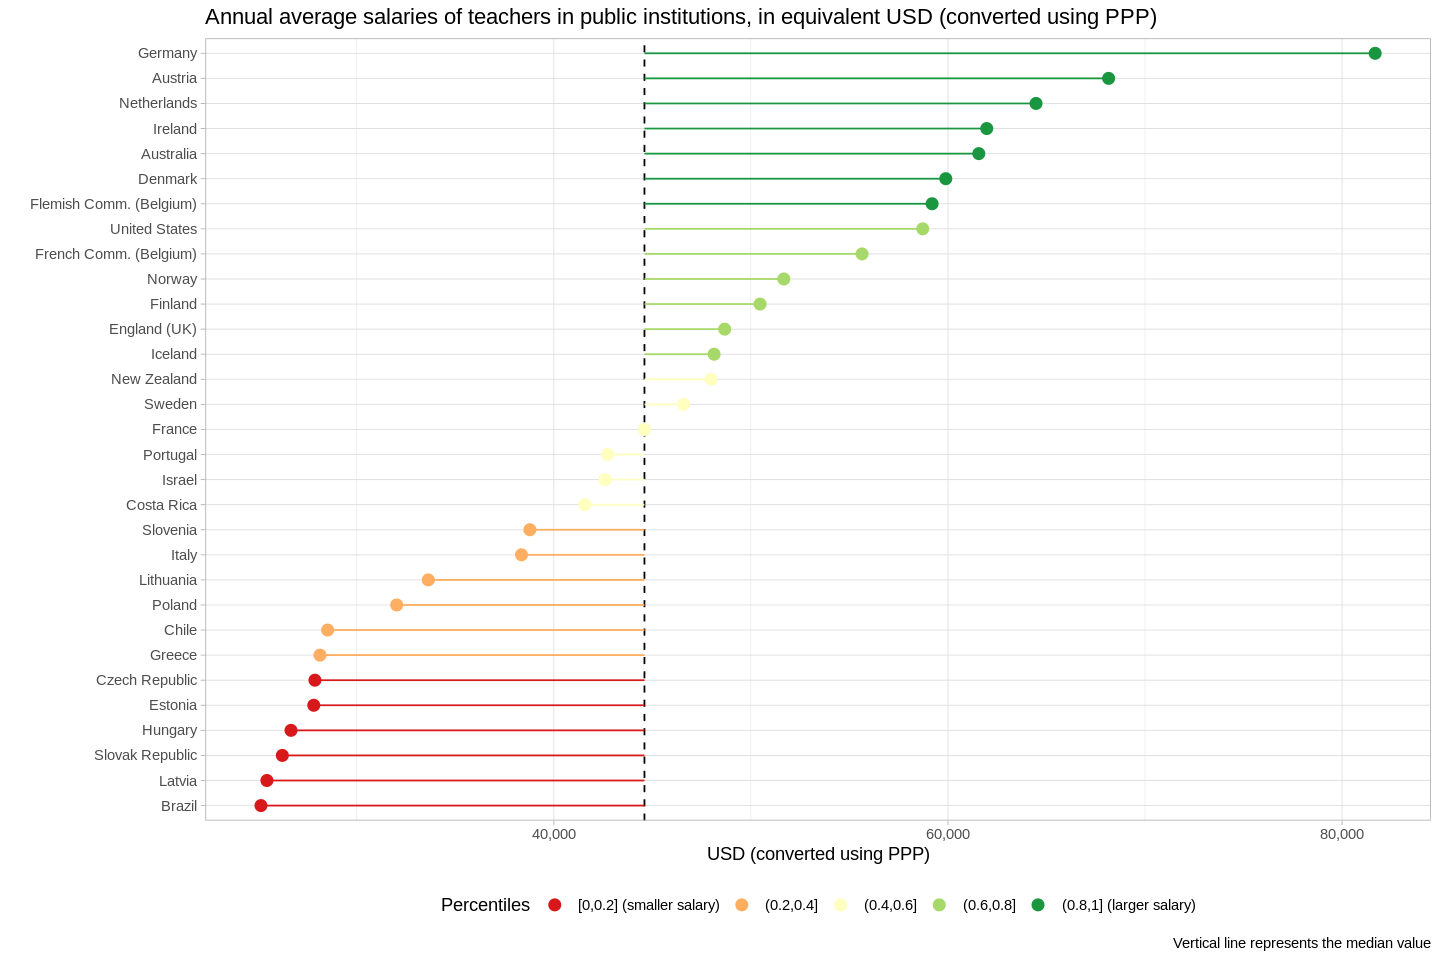

In [107]:
Data$Salary %>%
mutate(
  country = fct_reorder(country, value),
  median_value = median(value)
  # centered_value = value - median_value
) %>%

ggplot(aes(x = country, y = value, color = percentile_bin)) +
geom_hline(aes(yintercept = median_value), linetype = 'dashed') +
geom_segment(aes(xend = country, yend = median_value), show.legend = F) +
geom_point(size = 3) +
coord_flip() +
scale_y_continuous(labels = scales::comma_format(1)) +
scale_color_brewer(
  palette = 'RdYlGn',
  # direction = -1,
  labels = salary_labels) +
theme_light() +
theme(legend.position = 'bottom') +
labs(
  x = '', 
  title = 'Annual average salaries of teachers in public institutions, in equivalent USD (converted using PPP)',
  caption = 'Vertical line represents the median value',
  y = 'USD (converted using PPP)', 
  color = 'Percentiles')

In [42]:
Data$TimeWorking$indicator[[1]]

[1] "Total statutory working time per school year, in hours (teachers)"

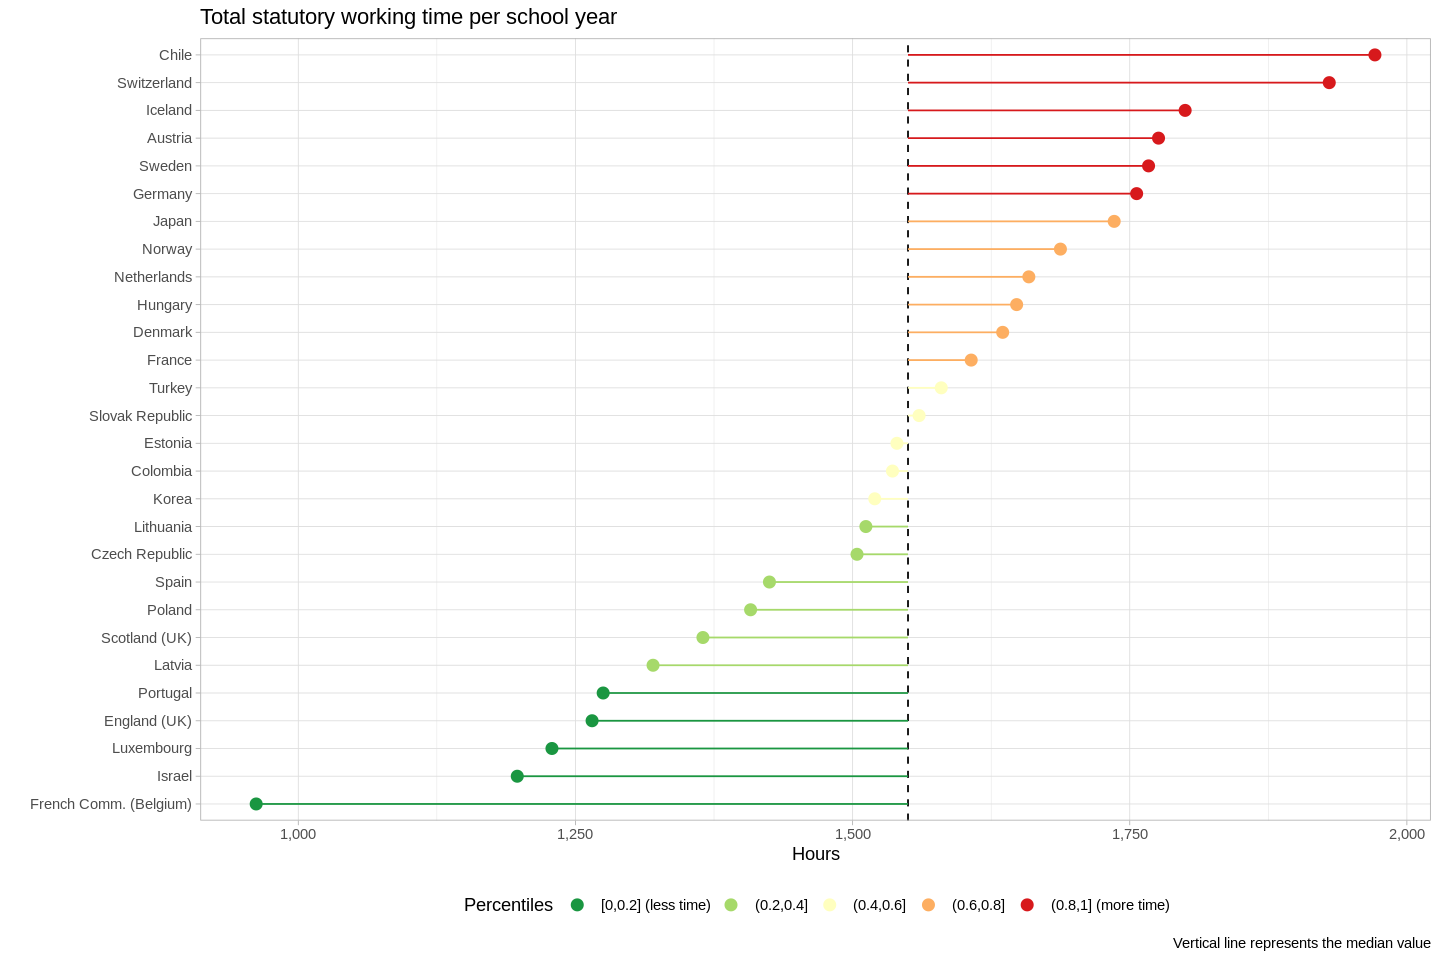

In [106]:
Data$TimeWorking %>%
mutate(
  country = fct_reorder(country, value),
  median_value = median(value)
) %>%

ggplot(aes(x = country, y = value, color = percentile_bin)) +
geom_hline(aes(yintercept = median_value), linetype = 'dashed') +
geom_segment(aes(xend = country, yend = median_value), show.legend = F) +
geom_point(size = 3) +
coord_flip() +
scale_y_continuous(labels = scales::comma_format(1)) +
scale_color_brewer(
  palette = 'RdYlGn',
  direction = -1,
  labels = time_use_labels) +
theme_light() +
theme(legend.position = 'bottom') +
labs(
  x = '', 
  title = 'Total statutory working time per school year',
  caption = 'Vertical line represents the median value',
  y = 'Hours', 
  color = 'Percentiles')

PISA

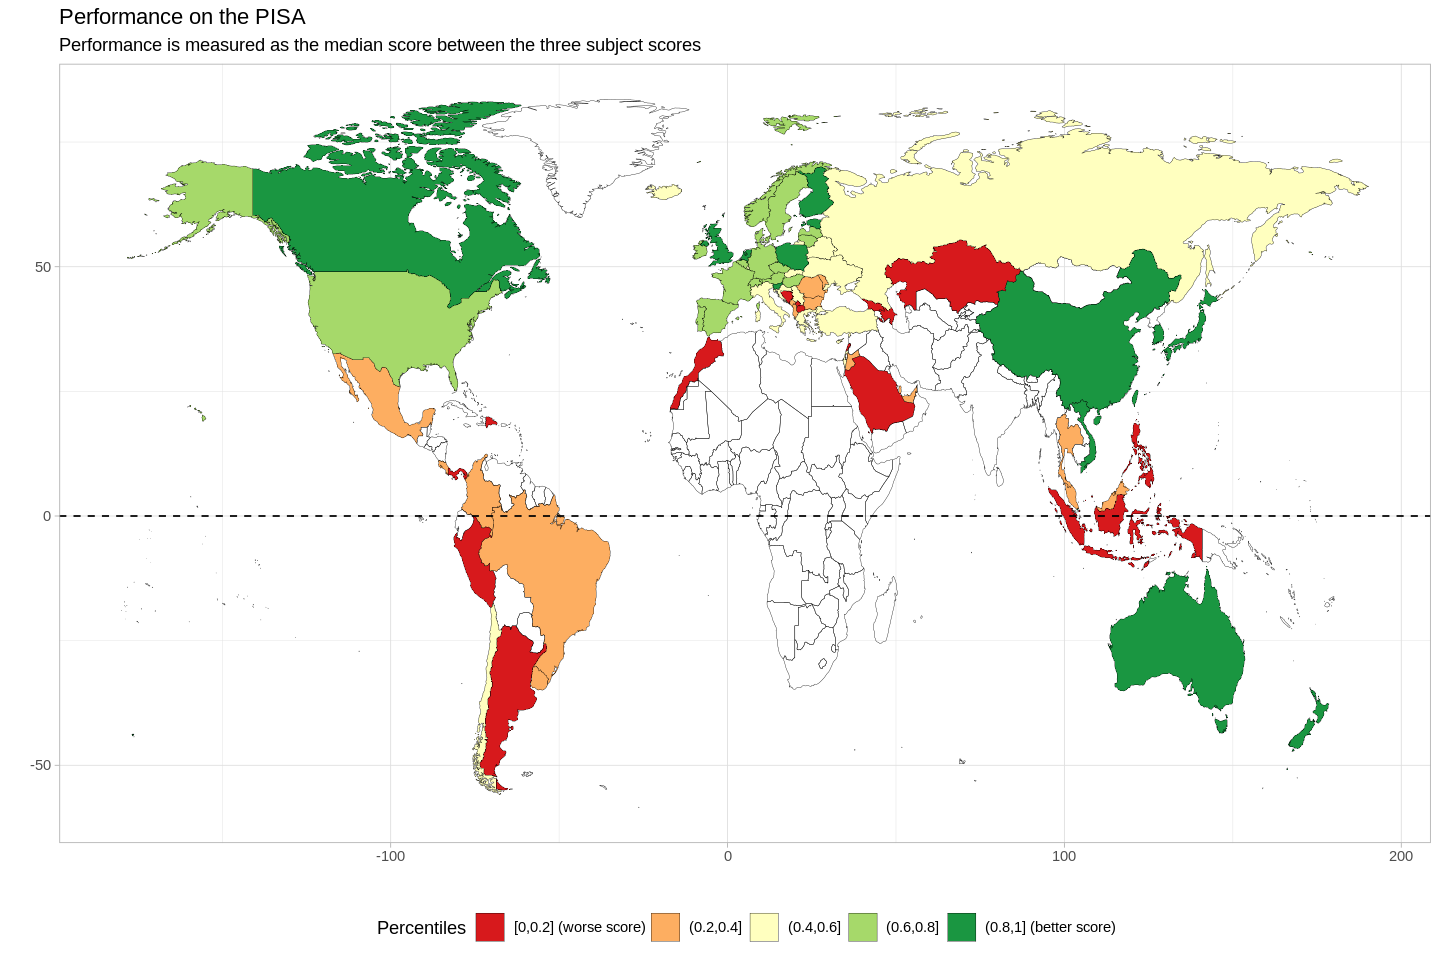

In [99]:
Data$PisaAgg %>%
right_join(Data$World, by = c('country' = 'region')) %>%

ggplot(., aes(x = long, y = lat, group = group, fill = pisa_percentile_bin)) +
geom_polygon(color = 'black', size = 0.1) +
geom_hline(yintercept = 0, linetype = 'dashed') +
scale_fill_brewer(
  palette = 'RdYlGn', 
  # direction = -1,
  breaks = c(
    '[0,0.2]',
    '(0.2,0.4]',
    '(0.4,0.6]',
    '(0.6,0.8]',
    '(0.8,1]'),
  labels = pisa_labels) +
guides(fill = guide_legend(nrow = 1)) +
theme_light() +
theme(legend.position = 'bottom') +
labs(x = '', y = '', 
  title = 'Performance on the PISA', 
  subtitle = 'Performance is measured as the median score between the three subject scores',
  fill = 'Percentiles')

In [100]:
head(Data$PisaAgg)

country,score,pisa_sd,pisa_percentile,pisa_percentile_bin
<chr>,<dbl>,<dbl>,<dbl>,<ord>
Albania,417,-0.7725047,0.2531646,"(0.2,0.4]"
Argentina,402,-1.0558281,0.1772152,"[0,0.2]"
Australia,503,0.8518830,0.8101266,"(0.8,1]"
Austria,490,0.6063361,0.6455696,"(0.6,0.8]"
Azerbaijan,398,-1.1313810,0.1518987,"[0,0.2]"
Belarus,472,0.2663479,0.5316456,"(0.4,0.6]"


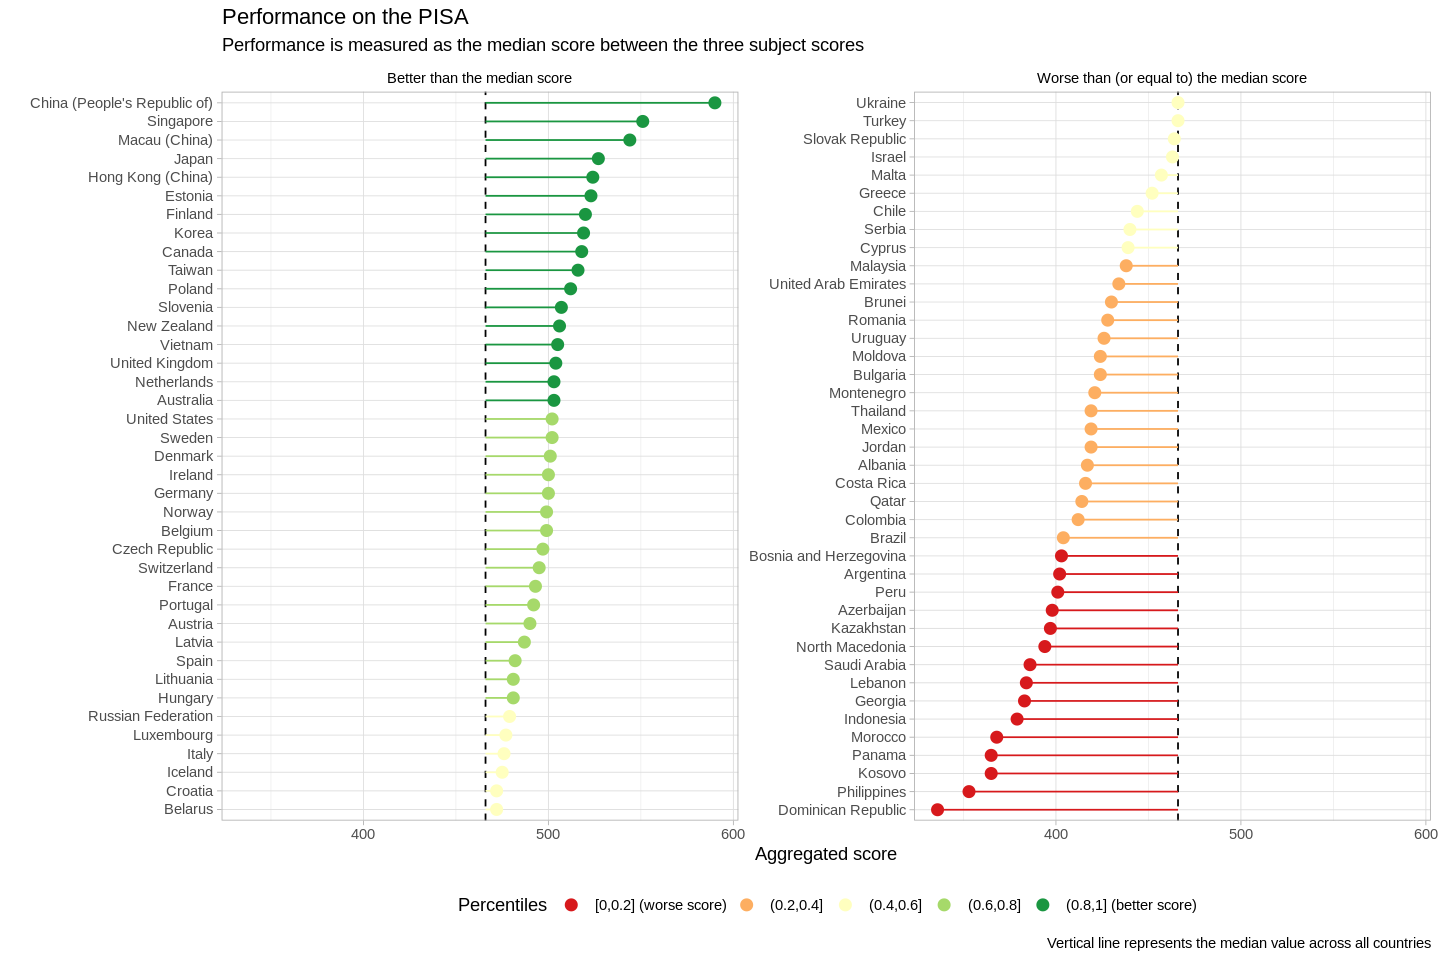

In [116]:
Data$PisaAgg %>%
mutate(
  country = fct_reorder(country, score),
  median_score = median(score),
  my_facet = if_else(score > median_score, 'Better than the median score', 'Worse than (or equal to) the median score'),
) %>%

ggplot(aes(x = country, y = score, color = pisa_percentile_bin)) +
geom_hline(aes(yintercept = median_score), linetype = 'dashed') +
geom_segment(aes(xend = country, yend = median_score), show.legend = F) +
geom_point(size = 3) +
coord_flip() +
scale_y_continuous(labels = scales::comma_format(1)) +
scale_color_brewer(
  palette = 'RdYlGn',
  labels = pisa_labels) +
facet_wrap(~my_facet, scales = 'free_y') +
theme_light() +
theme(
  strip.text = element_text(color = 'black'),
  strip.background = element_blank(),
  legend.position = 'bottom') +
labs(
  x = '', 
  title = 'Performance on the PISA', 
  subtitle = 'Performance is measured as the median score between the three subject scores',
  caption = 'Vertical line represents the median value across all countries',
  y = 'Aggregated score', 
  color = 'Percentiles')

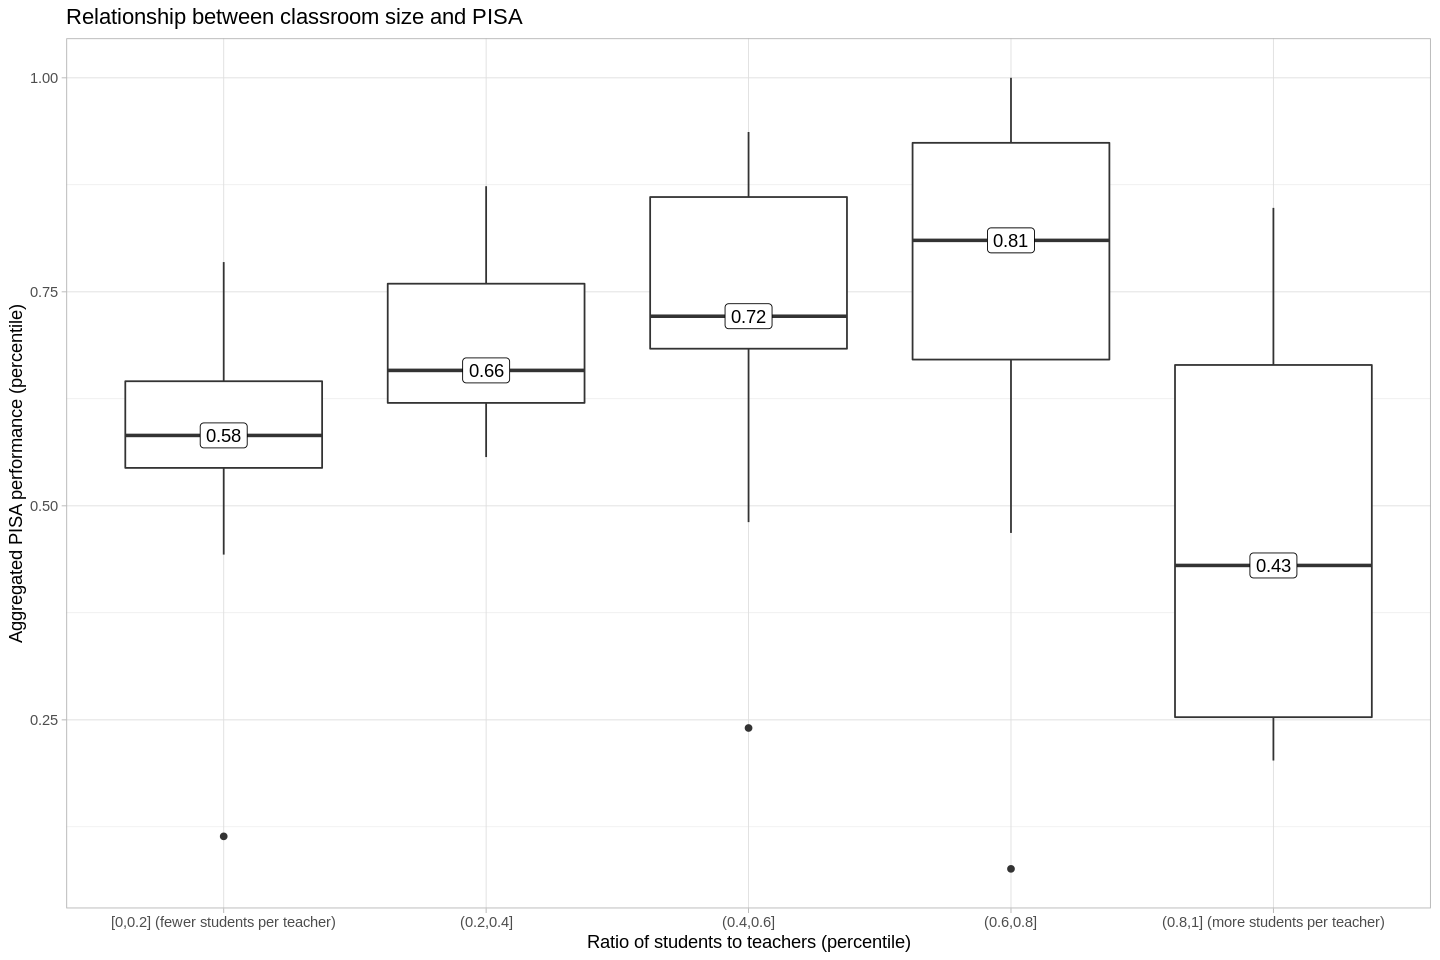

In [44]:
with(Data, inner_join(Ratio, PisaAgg, by = 'country')) %>%
ggplot(aes(x = percentile_bin, y = pisa_percentile)) +
geom_boxplot() +
stat_summary(fun = 'median', geom = 'label', aes(label = round(..y.., 2))) +
scale_x_discrete(labels = ratio_labels) +
theme_light() +
labs(
  title = 'Relationship between classroom size and PISA',
  x = 'Ratio of students to teachers (percentile)',
  y = 'Aggregated PISA performance (percentile)'
)

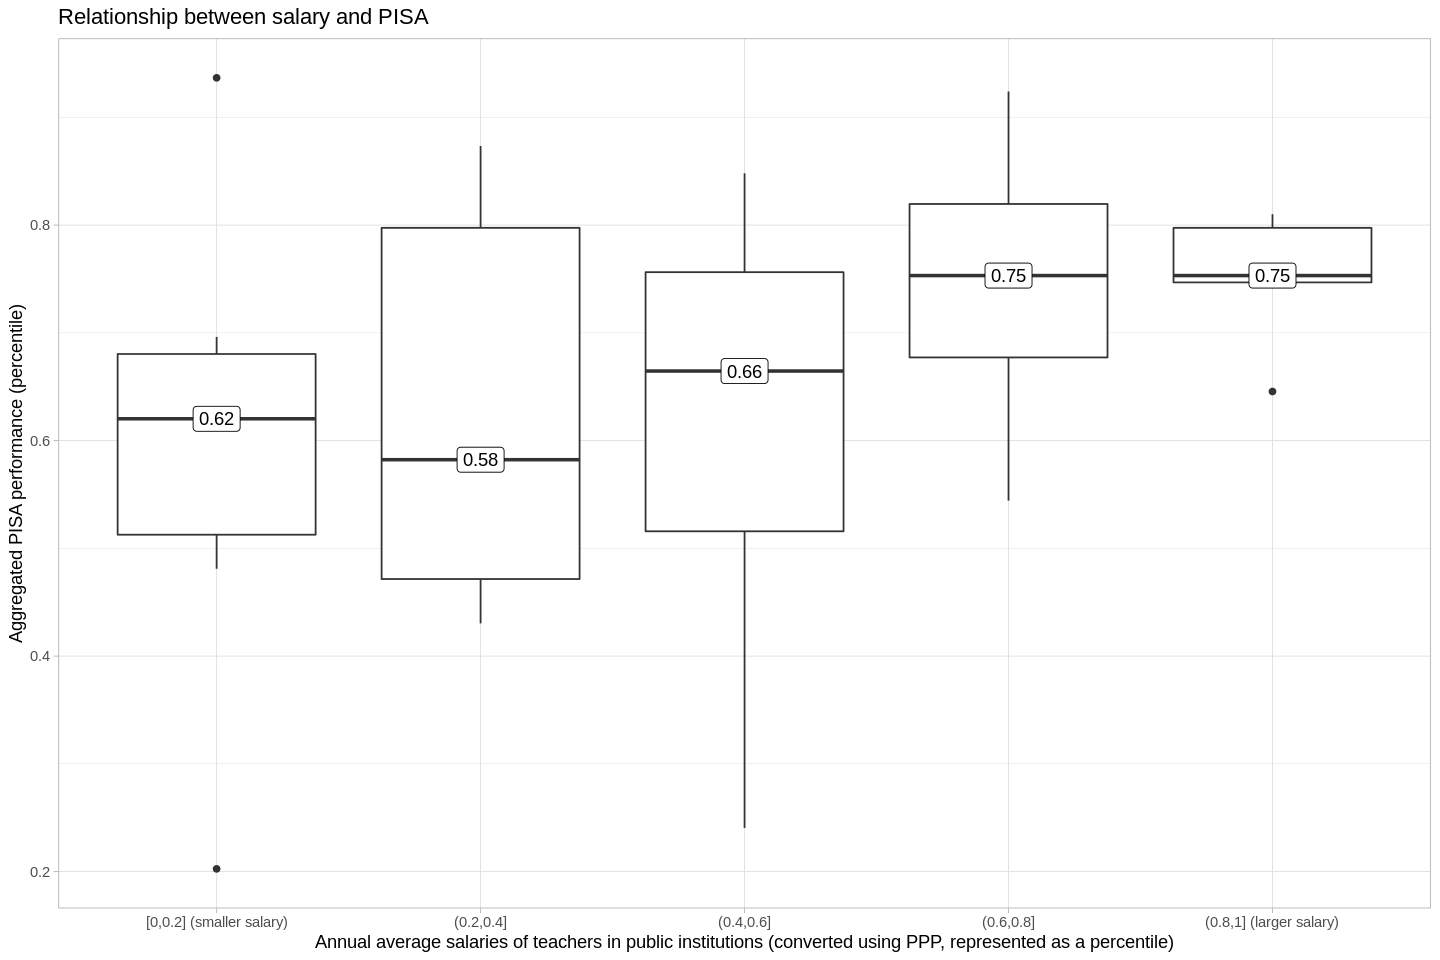

In [45]:
with(Data, inner_join(Salary, PisaAgg, by = 'country')) %>%
ggplot(aes(x = percentile_bin, y = pisa_percentile)) +
geom_boxplot() +
stat_summary(fun = 'median', geom = 'label', aes(label = round(..y.., 2))) +
scale_x_discrete(labels = salary_labels) +
theme_light() +
labs(
  title = 'Relationship between salary and PISA',
  x = 'Annual average salaries of teachers in public institutions (converted using PPP, represented as a percentile)',
  y = 'Aggregated PISA performance (percentile)'
)

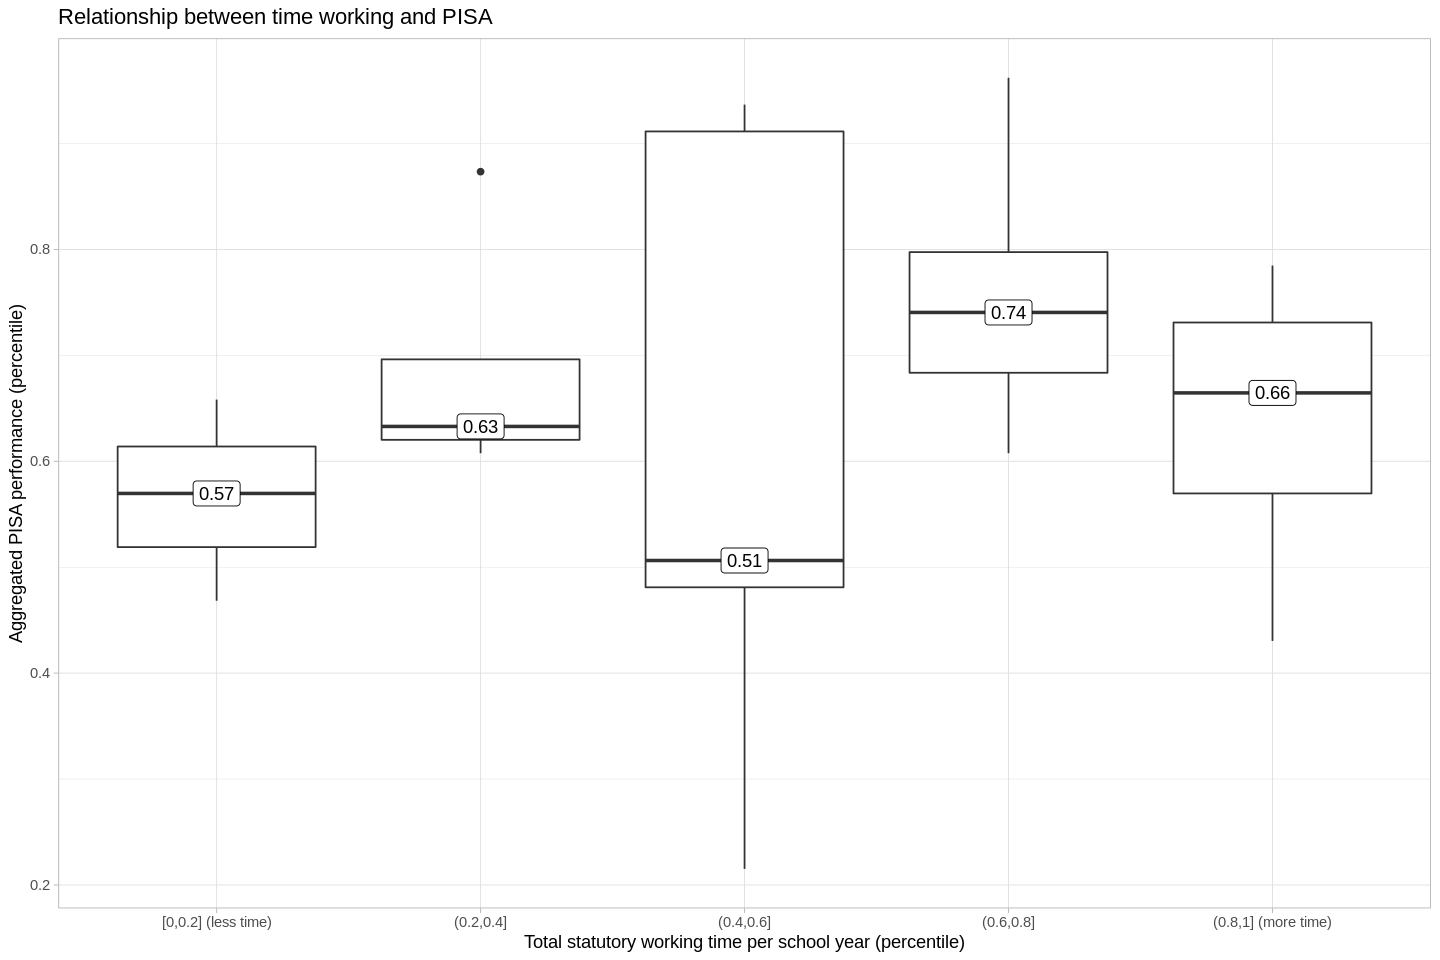

In [46]:
with(Data, inner_join(TimeWorking, PisaAgg, by = 'country')) %>%
ggplot(aes(x = percentile_bin, y = pisa_percentile)) +
geom_boxplot() +
stat_summary(fun = 'median', geom = 'label', aes(label = round(..y.., 2))) +
scale_x_discrete(labels = time_use_labels) +
theme_light() +
labs(
  title = 'Relationship between time working and PISA',
  x = 'Total statutory working time per school year (percentile)',
  y = 'Aggregated PISA performance (percentile)'
)

In [47]:
report_spearman_cor <- function(Htest){
  str_c(
    'Spearman\'s rank correlation rho = ', 
    round(Htest$estimate, 2), 
    '(s = ', scales::comma(Htest$statistic), 
    if_else(
      Htest$p.value < 0.05, 
      ' p < 0.05; significant)',
      ' p >= 0.05; not significant)'
    ),
    '\nRegression line represents LOESS model')
}

Warning message in cor.test.default(value, score, method = "s"):
“Cannot compute exact p-value with ties”
Warning message:
“ggrepel: 13 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


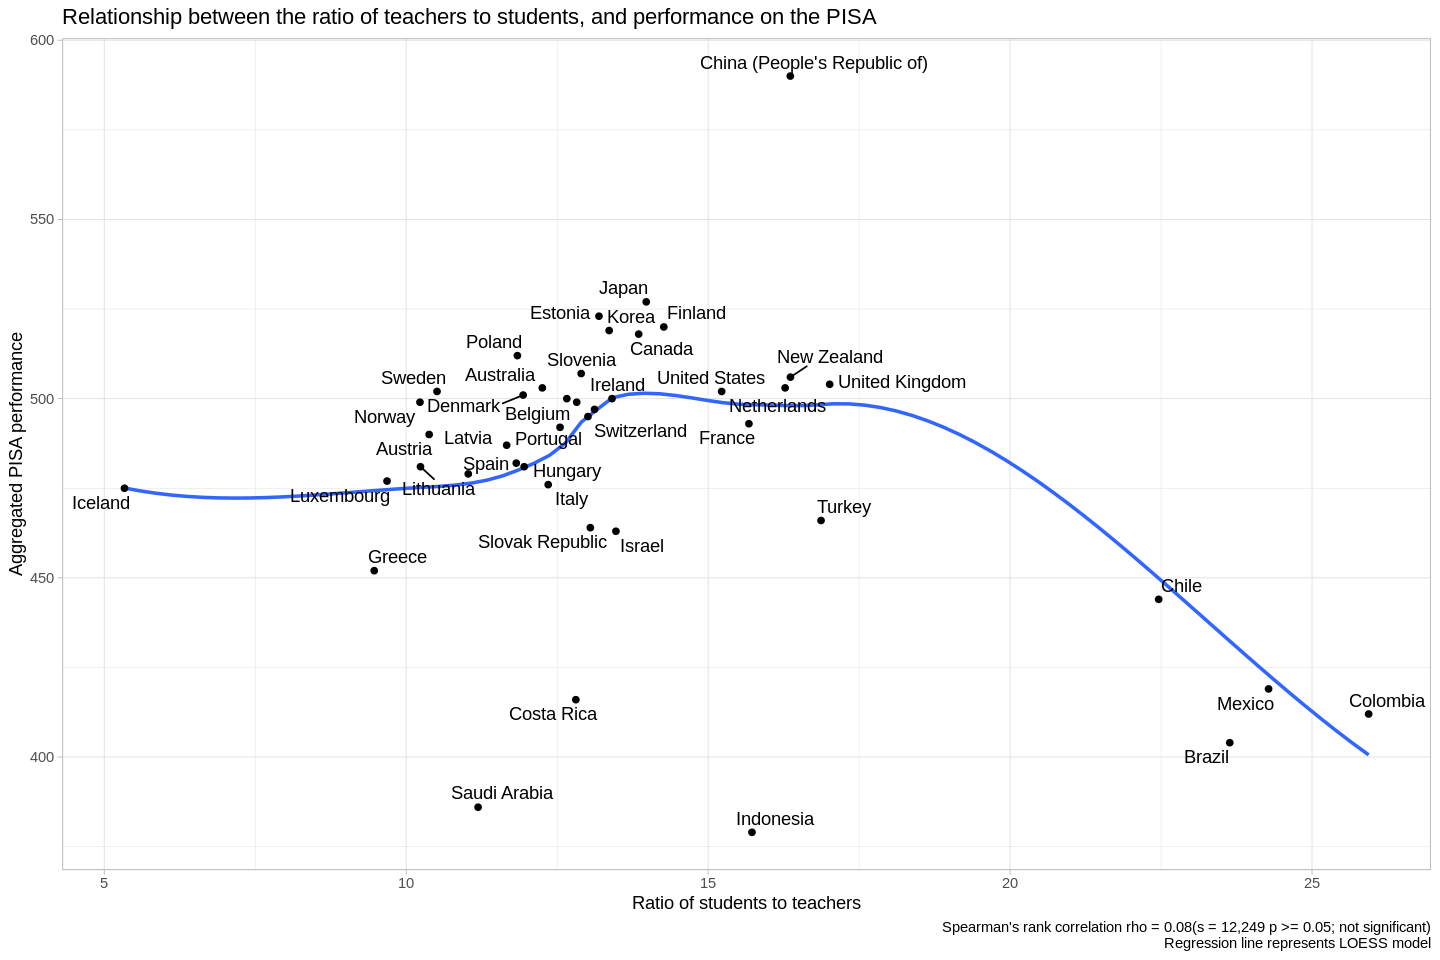

In [48]:
my_caption <- 
  with(Data, inner_join(PisaAgg, Ratio, by = 'country')) %>%
  drop_na %>%
  with(., cor.test(value, score, method = 's')) %>%
  report_spearman_cor

with(Data, inner_join(PisaAgg, Ratio, by = 'country')) %>%
drop_na %>%
ggplot(aes(x = value, y = score, label = country)) +
geom_smooth(se = F, method = 'loess', formula = 'y ~ x') +
geom_text_repel() +
geom_point() +
theme_light() +
labs(
  x = 'Ratio of students to teachers', 
  y = 'Aggregated PISA performance', 
  title = 'Relationship between the ratio of teachers to students, and performance on the PISA',
  caption = my_caption
  )

Warning message in cor.test.default(value, score, method = "s"):
“Cannot compute exact p-value with ties”


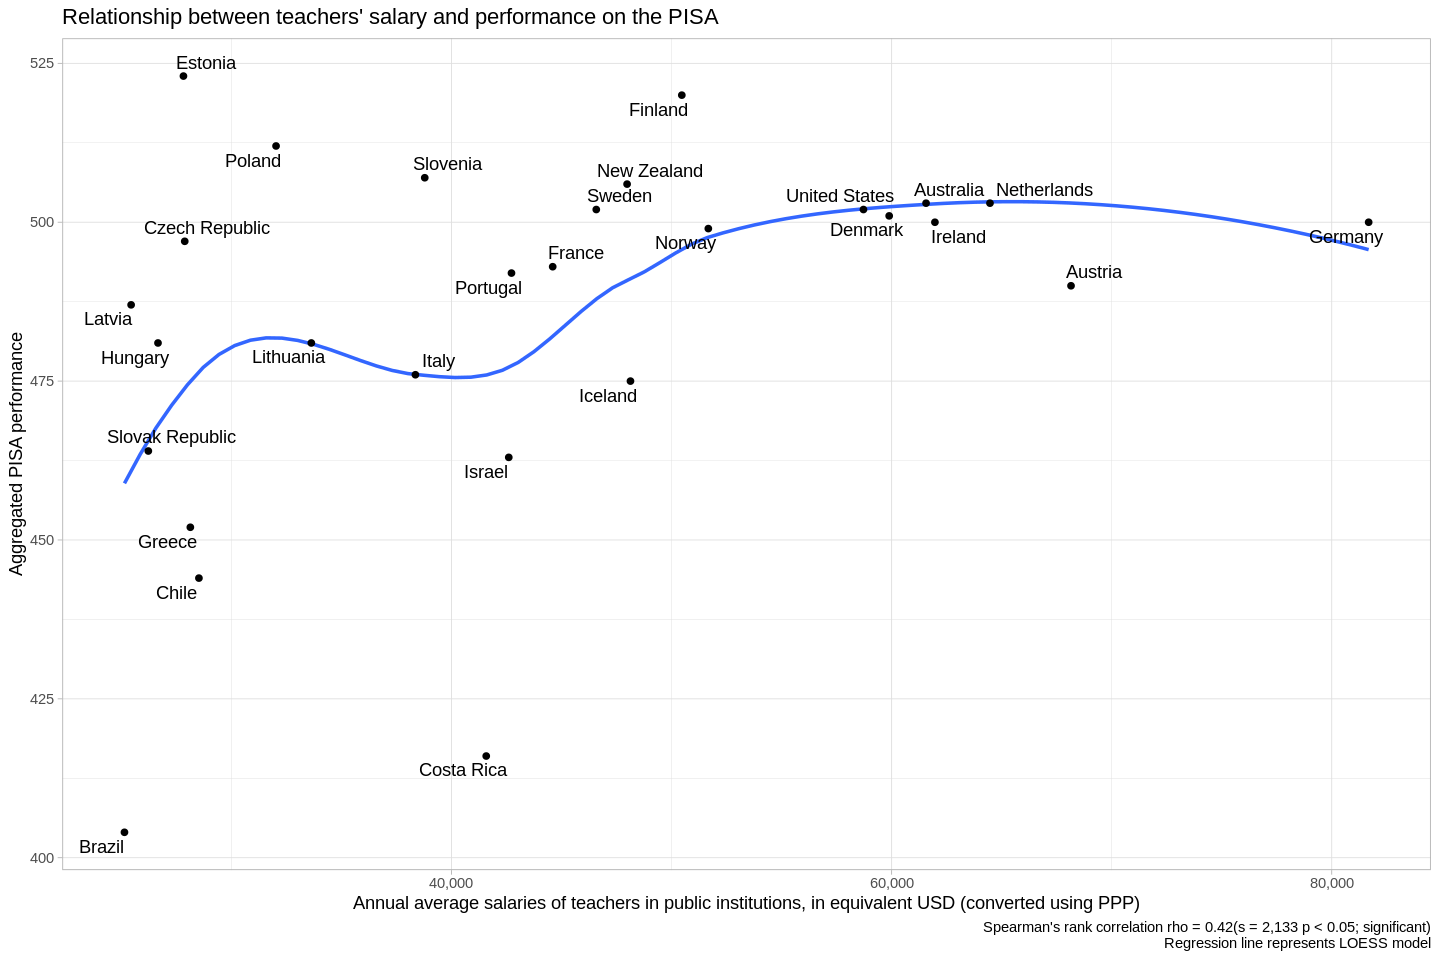

In [49]:
my_caption <-
  with(Data, inner_join(PisaAgg, Salary, by = 'country')) %>%
  drop_na %>%
  with(., cor.test(value, score, method = 's')) %>%
  report_spearman_cor

with(Data, inner_join(PisaAgg, Salary, by = 'country')) %>%
drop_na %>%
ggplot(aes(x = value, y = score, label = country)) +
geom_smooth(se = F, method = 'loess', formula = 'y ~ x') +
geom_text_repel() +
geom_point() +
scale_x_continuous(labels = scales::comma_format(1)) +
theme_light() +
labs(
  x = 'Annual average salaries of teachers in public institutions, in equivalent USD (converted using PPP)',
  y = 'Aggregated PISA performance', 
  title = 'Relationship between teachers\' salary and performance on the PISA',
  caption = my_caption
  )

Warning message in cor.test.default(value, score, method = "s"):
“Cannot compute exact p-value with ties”


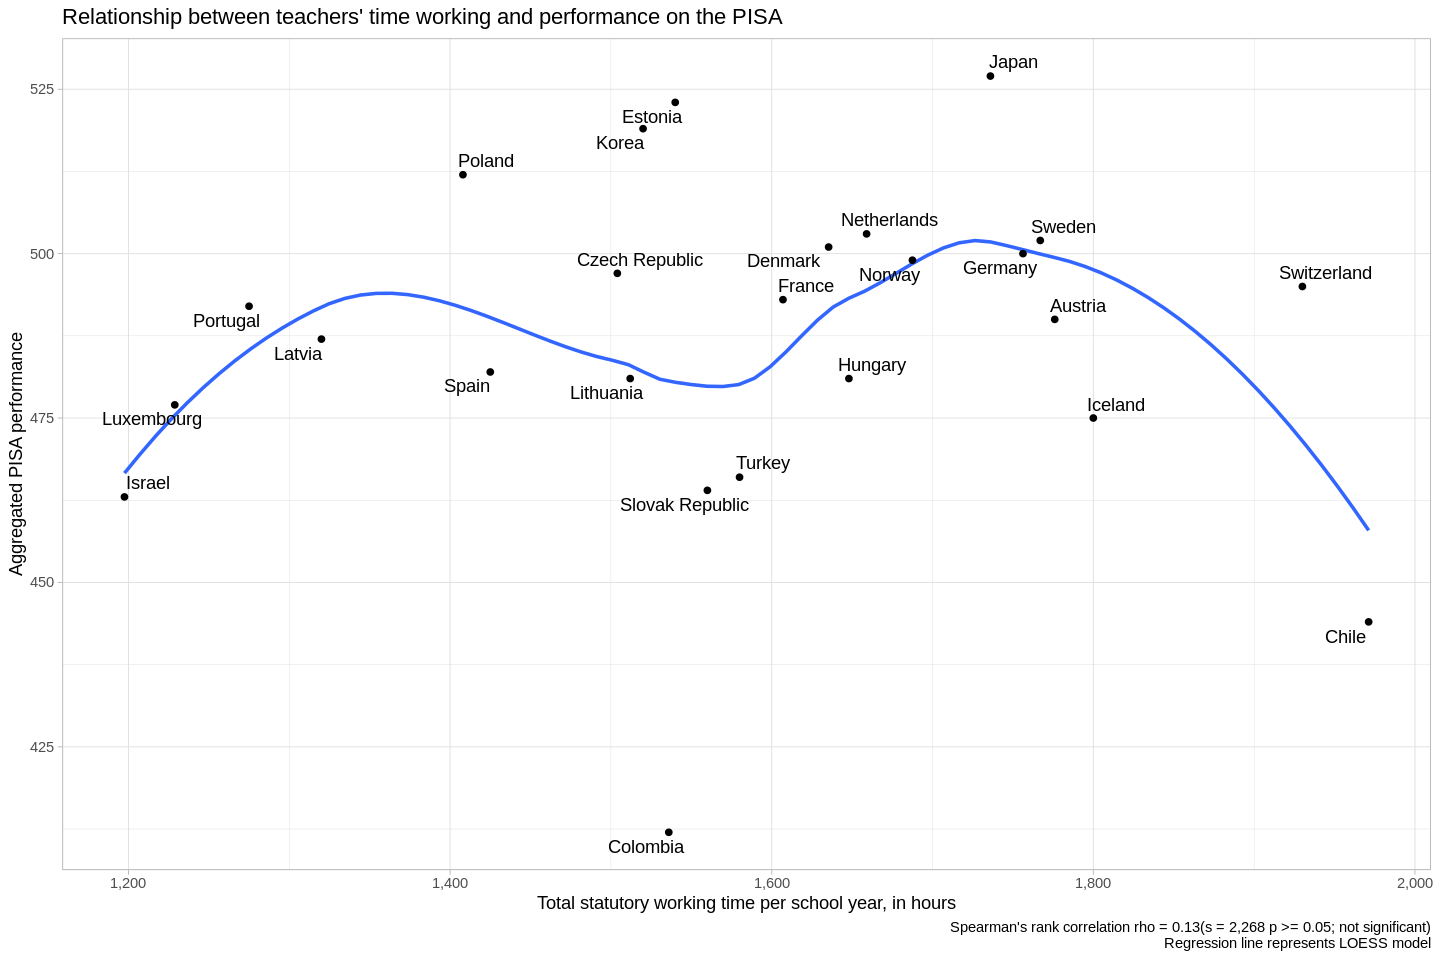

In [50]:
my_caption <-
  with(Data, inner_join(PisaAgg, TimeWorking, by = 'country')) %>%
  drop_na %>%
  with(., cor.test(value, score, method = 's')) %>%
  report_spearman_cor

with(Data, inner_join(PisaAgg, TimeWorking, by = 'country')) %>%
drop_na %>%
ggplot(aes(x = value, y = score, label = country)) +
geom_smooth(se = F, method = 'loess', formula = 'y ~ x') +
geom_text_repel() +
geom_point() +
scale_x_continuous(labels = scales::comma_format(1)) +
theme_light() +
labs(
  x = 'Total statutory working time per school year, in hours',
  y = 'Aggregated PISA performance', 
  title = 'Relationship between teachers\' time working and performance on the PISA',
  caption = my_caption
)

In [60]:
Data$PisaAgg %>%
head

country,score,pisa_sd,pisa_percentile
<chr>,<dbl>,<dbl>,<dbl>
Albania,417,-0.7725047,0.2531646
Argentina,402,-1.0558281,0.1772152
Australia,503,0.8518830,0.8101266
Austria,490,0.6063361,0.6455696
Azerbaijan,398,-1.1313810,0.1518987
Belarus,472,0.2663479,0.5316456


Top-line summary of models

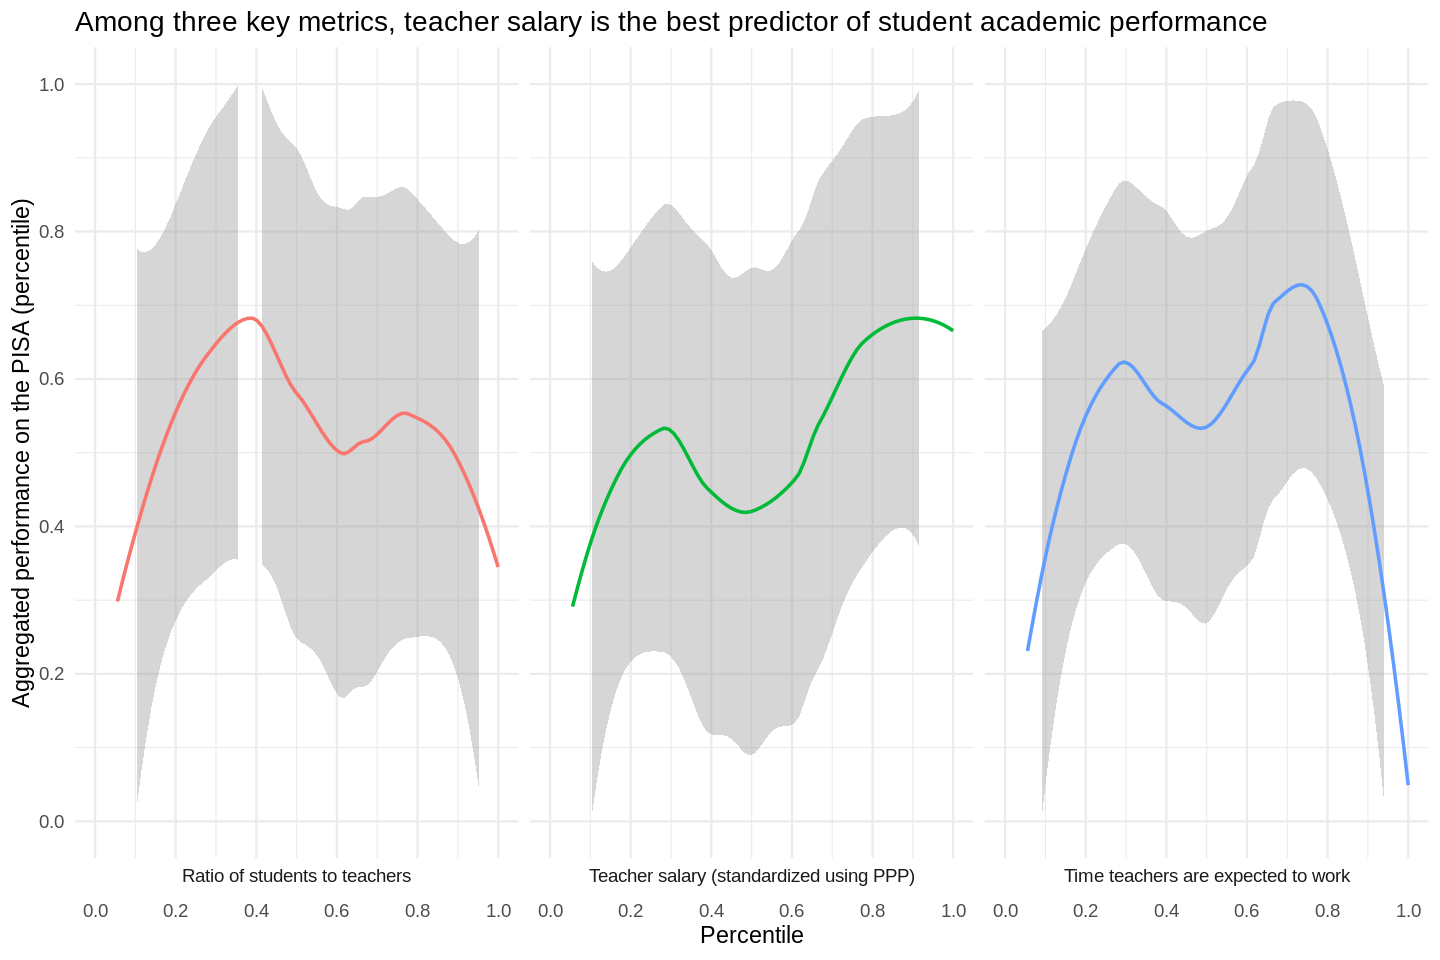

In [118]:
Data$Salary %>%
select(country, 'Teacher salary (standardized using PPP)' = value) %>%
inner_join(
  Data$Ratio %>%
  select(country, 'Ratio of students to teachers' = value), by = 'country'
) %>%
inner_join(
  Data$TimeWorking %>%
  select(country, 'Time teachers are expected to work' = value), by = 'country'
) %>%
inner_join(
  Data$PisaAgg %>%
  select(country, 'Aggregated performance on the PISA' = score), by = 'country'
) %>%
mutate_if(is.numeric, ~ecdf(.)(.)) %>%
gather(variable, value, -country, -`Aggregated performance on the PISA`) %>%

ggplot(aes(x = value, y = `Aggregated performance on the PISA`, group = variable)) +
geom_smooth(method = 'loess', formula = 'y ~ x', se = T, aes(color = variable)) +
facet_wrap(~variable, strip.position = 'bottom') +
scale_x_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.2)) +
scale_y_continuous(limits = c(0, 1), breaks = seq(0, 1, by = 0.2)) +
theme_minimal(base_size = 14) +
theme(legend.position = 'none') +
labs(
  x = 'Percentile',
  y = 'Aggregated performance on the PISA (percentile)',
  title = 'Among three key metrics, teacher salary is the best predictor of student academic performance'
)

# Social outcomes

It'd be nice to use a structural equation model to express the relationships between these variables, and it'd be even nicer to use latent variables to represent larger patterns where applicable.
Unfortunately, a few key packages for dimensionality reduction don't work with this R kernel, in this Colab notebook. 
So, I'll rationalize and say that with only 4 manifest social outcome variables, and only 3 manifest teacher variables, I can just look at correlation matrices and construct some common-sense latent variables.

Latent variable 1:
- Mean # of hours worked 
- % of adults who reported it's difficult for them to fulfill family responsibilities for lack of time

Latent variable 2:
- Work flexibility
- % of adults who read books at least once a week

In [119]:
rho <-
  Data$SocialOutcomes %>%
  select(-indicator_concise) %>%
  spread(indicator, value) %>%
  rename(
    'Percentage of adults who read books at least once a week' = 'Percentage of adults who read books at least once a week, by labour-force status, gender, age and educational attainment'
  ) %>%
  select_if(is.numeric) %>%
  mutate_all(~as.vector(scale(.))) %>%
  cor(., use = 'pairwise.complete.obs', method = 's')

rho[upper.tri(rho, diag = T)] <- NA_real_
round(rho, 2)

,Mean number of hours worked per week in the main job among employed adults,Percentage of adults who read books at least once a week,Percentage of adults who reported that over the last 12 months it has been difficult for them to fulfil their family responsibilities because of the amount of time they spend at work,Percentage of employed adults who report having a high or very high flexibility of working hours in their main job
Mean number of hours worked per week in the main job among employed adults,NA,NA,NA,NA
Percentage of adults who read books at least once a week,-0.55,NA,NA,NA
Percentage of adults who reported that over the last 12 months it has been difficult for them to fulfil their family responsibilities because of the amount of time they spend at work,0.49,-0.31,NA,NA
Percentage of employed adults who report having a high or very high flexibility of working hours in their main job,-0.21,0.17,-0.24,NA


Latent variable:
- Time working
- Salary

Our lone wolf manifest variable:
- Ratio of students to teachers

In [53]:
rho <-
  Data$Salary %>% 
  select(country, salary = value) %>%

  full_join(
    Data$Ratio %>%
    select(country, ratio_students_to_teachers = value), by = 'country'
  ) %>%

  full_join(
    Data$TimeWorking %>%
    select(country, time_working = value), by = 'country'
  ) %>%
  select_if(is.numeric) %>%
  mutate_all(scale) %>%
  cor(method = 's', use = 'pairwise.complete.obs') 
  
rho[upper.tri(rho, diag = T)] <- NA_real_
round(rho, 2)

,salary,ratio_students_to_teachers,time_working
salary,NA,NA,NA
ratio_students_to_teachers,-0.04,NA,NA
time_working,0.28,0.05,NA


In [54]:
X <-
  # Variables about teachers
  Data$Salary %>% 
  select(country, salary = value) %>%

  full_join(
    Data$Ratio %>%
    select(country, ratio_students_to_teachers = value), by = 'country'
  ) %>%

  full_join(
    Data$TimeWorking %>%
    select(country, time_working = value), by = 'country'
  ) %>%

  # PISA
  full_join(
    Data$PisaAgg %>%
    select(country, pisa = score), by = 'country'
  ) %>%

  # Social outcomes
  full_join(
    Data$SocialOutcomes %>%
    select(country, indicator_concise, value) %>%
    spread(indicator_concise, value), by = 'country'
  ) %>%
  select(-country) %>%
  mutate_all(~as.vector(scale(.)))

In [69]:
sem_formula <- '
  # latent variables
  teacher_time_and_pay =~ time_working + salary
  outcome_flex_and_read =~ work_flexibility + read_books
  outcome_work_and_home_stress =~ hours_worked + conflict_work_family_time

  # regressions
  outcome_flex_and_read ~ teacher_time_and_pay
  outcome_flex_and_read ~ ratio_students_to_teachers
  outcome_work_and_home_stress ~ teacher_time_and_pay
  outcome_work_and_home_stress ~ ratio_students_to_teachers

  # correlations
  pisa ~~ teacher_time_and_pay
  pisa ~~ ratio_students_to_teachers
  pisa ~~ outcome_flex_and_read 
  pisa ~~ outcome_work_and_home_stress 
'

In [71]:
anova(cfa(sem_formula, X))

Warning message in lav_object_post_check(object):
“lavaan WARNING: some estimated ov variances are negative”


,Df,AIC,BIC,Chisq,Chisq diff,Df diff,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
Saturated,0,NA,NA,0.00000,NA,NA,NA
Model,13,241.7041,254.698,22.01934,22.01934,13,0.05506289


In [70]:
cfa(sem_formula, X) %>%
summary

Warning message in lav_object_post_check(object):
“lavaan WARNING: some estimated ov variances are negative”


lavaan 0.6-8 ended normally after 74 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        23
                                                      
                                                  Used       Total
  Number of observations                            13          87
                                                                  
Model Test User Model:
                                                      
  Test statistic                                22.019
  Degrees of freedom                                13
  P-value (Chi-square)                           0.055

Parameter Estimates:

  Standard errors                             Standard
  Information                                 Expected
  Information saturated (h1) model          Structured

Latent Variables:
                                  Estimate  Std.Err  z-value  P(>|z|)
  teacher_